In [1]:
import numpy as np

import mlgrad.avragg as avragg
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.regnorm as regular

from mlgrad.regr import averaging_function, regression, m_regression_irls, \
                        r_regression_irls, m_regression, \
                        plot_losses_and_errors, plot_yy, exclude_outliers

from mlgrad import erm_fg, erm_sg, erm_irgd, fg, fg_rud, sg, weights, averager_it, erisk, mrisk

from pprint import pprint

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import sys
print(sys.version)

3.9.10 (main, Jan 16 2022, 17:12:18) 
[GCC 11.2.0]


In [2]:
X, Y = load_boston(return_X_y=True)
# print(X.shape)

# Is = [i for i,y in enumerate(Y) if y != 50]
# X = X[Is]
# Y = Y[Is]

scaler = StandardScaler()
Xt = scaler.fit_transform(X)


/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :fu

In [3]:
def sigma_neuron_layer2(n_input, n_output):
    outfunc = func.Arctang()
    layer = model.SigmaNeuronModelLayer(outfunc, n_input, n_output)
    return layer

In [4]:
def create_nn(n_input, n_layers):
    body = model.FFNetworkModel()
    n_prev_layer = n_input
    for n_layer in n_layers:
        layer = sigma_neuron_layer2(n_prev_layer, n_layer)
        n_prev_layer = n_layer
        body.add(layer)

    head = model.LinearModel(n_layers[-1])
    ffnn = model.FFNetworkFuncModel(head, body)
    ffnn.allocate()
    return ffnn

In [5]:
loss_func_sq = loss.ErrorLoss(func.Square())
loss_func_sqrt = loss.ErrorLoss(func.Sqrt(1.0))

In [6]:
n_hidden1 = 27
n_hidden2 = 13
n_layers = (n_hidden1, n_hidden2)
n_input = Xt.shape[1]

In [7]:
ffnn1 = create_nn(n_input, n_layers)
ffnn1.init_param()
ffnn2 = create_nn(n_input, n_layers)
ffnn2.init_param()
ffnn3 = create_nn(n_input, n_layers)
ffnn3.init_param()
ffnn4 = create_nn(n_input, n_layers)
ffnn4.init_param()
ffnn5 = create_nn(n_input, n_layers)
ffnn5.init_param()

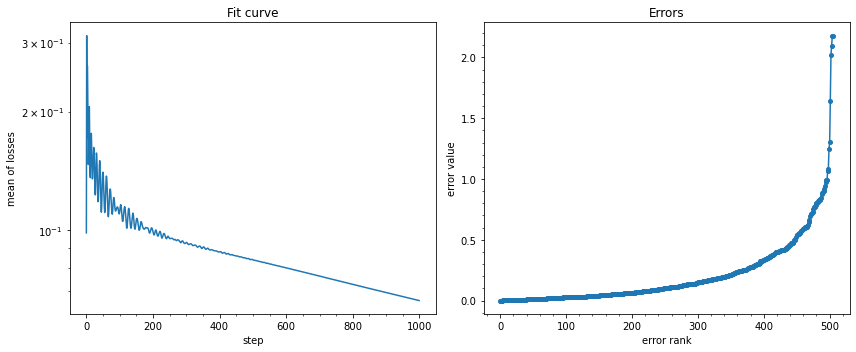

In [8]:
fg_bp = regression(Xt, Y, ffnn1, h=0.01, tol=1.0e-8, n_restart=5)
plot_losses_and_errors(fg_bp, Xt, Y)

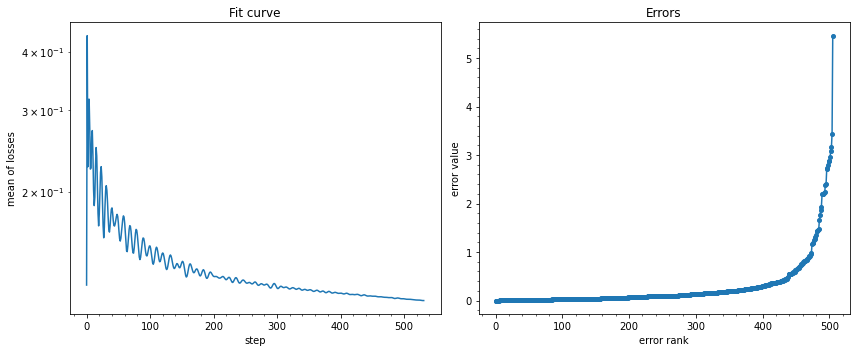

In [9]:
fg_sqrt = regression(Xt, Y, ffnn2, loss_func_sqrt, h=0.01, tol=1.0e-8, n_restart=5)
plot_losses_and_errors(fg_sqrt, Xt, Y)

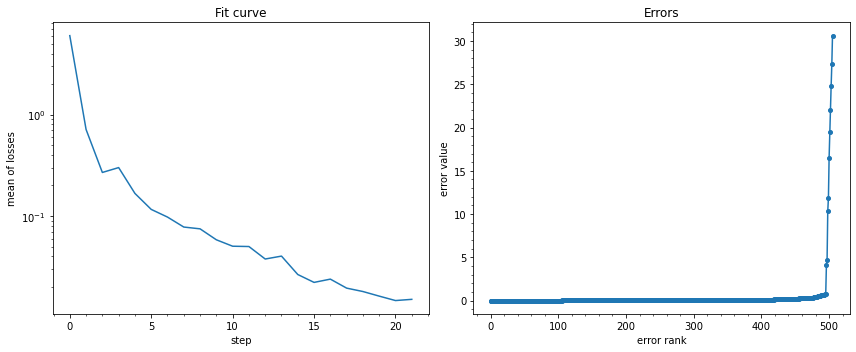

In [10]:
avg_wm = averaging_function("WM", rhofunc=func.Sqrt(0.001), alpha=0.98)
irgd_wm = m_regression_irls(Xt, Y, ffnn3, agg_func=avg_wm, h=0.01, tol=1.0e-8)
plot_losses_and_errors(irgd_wm, Xt, Y)

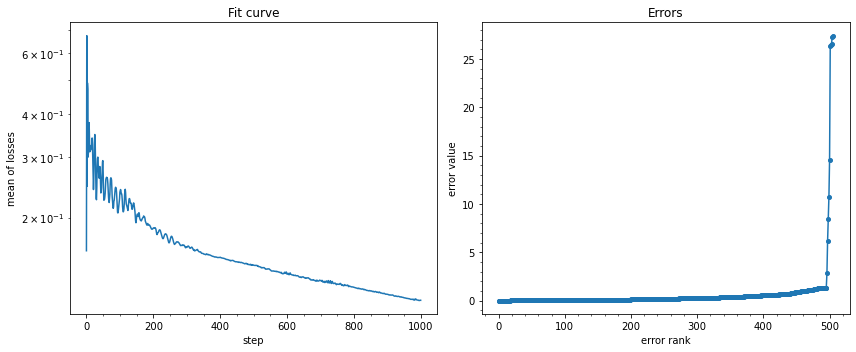

In [11]:
avg_22 = averaging_function("WM", rhofunc=func.Sqrt(0.001), alpha=0.98)
alg_fg2 = m_regression(Xt, Y, ffnn4, agg_func=avg_22, h=0.01, tol=1.0e-8, n_restart=5)
plot_losses_and_errors(alg_fg2, Xt, Y)

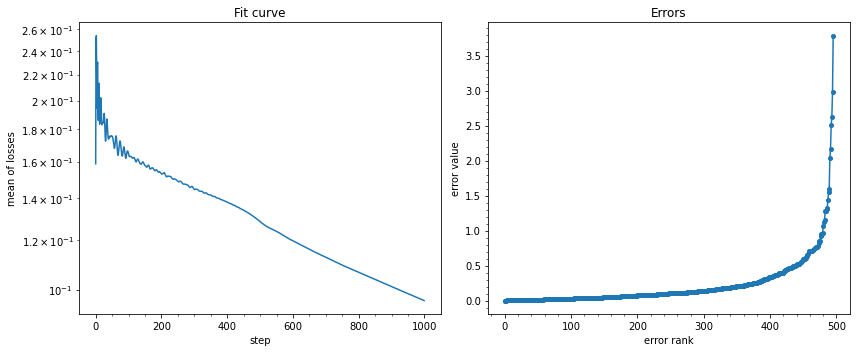

In [12]:
X_wo, Y_wo = exclude_outliers(ffnn3, Xt, Y, 10)
alg2 = regression(X_wo, Y_wo, ffnn5, h=0.01, tol=1.0e-8, n_restart=5)
plot_losses_and_errors(alg2, X_wo, Y_wo)

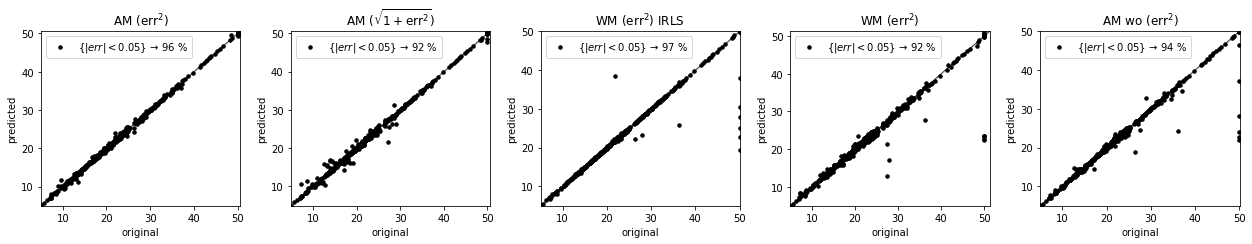

In [13]:
b=0.05
plt.figure(figsize=(5*3.5, 3.5))
plt.subplot(1,5,1)
plot_yy(Xt, Y, ffnn1, r'AM ($\mathrm{err}^2$)', b)
plt.subplot(1,5,2)
plot_yy(Xt, Y, ffnn2, r'AM ($\sqrt{1+\mathrm{err}^2}$)', b)
plt.subplot(1,5,3)
plot_yy(Xt, Y, ffnn3, r'WM ($\mathrm{err}^2$) IRLS', b)
plt.subplot(1,5,4)
plot_yy(Xt, Y, ffnn4, r'WM ($\mathrm{err}^2$)', b)
plt.subplot(1,5,5)
plot_yy(Xt, Y, ffnn5, r'AM wo ($\mathrm{err}^2$)', b)
plt.tight_layout()
plt.show()